## Growth Rate

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from src.utils import *
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})
from src.plotting import *
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

plt.rcParams['figure.facecolor'] = 'white'


In [3]:
ialp_2022 = pd.read_csv('data/raw/ialp_raw.csv', index_col=0, parse_dates=True)
df = ialp_2022[["Revenue","Spend"]].copy()
df.fillna(0, inplace=True)
df['ROAS'] = df['Revenue'] / df['Spend']
df = df.replace([np.inf, -np.inf], np.nan)


In [4]:
df = df.resample("MS").agg({
    "Revenue": "sum",
    "ROAS": "mean",
    "Spend": "sum"
})

df.head()

,Revenue,ROAS,Spend
Year_Month,,,
2022-01-01,125019.563844,11.366712,8708.959277
2022-02-01,180228.355912,15.585448,9288.315597
2022-03-01,220002.208116,21.504915,9750.634749
2022-04-01,112482.039968,15.630484,6698.680465
2022-05-01,147431.827870,12.379343,9816.206582


In [5]:
df_2019 = pd.read_excel('data/external/IALP_Monthly_2019_2021.xlsx', index_col=0, parse_dates=True)
df_2019.head()
df_2019 = df_2019[["Revenue","ROAS"]].copy()
df_2019["Spend"] = df_2019["Revenue"] / df_2019["ROAS"]


df_2019 = df_2019.fillna(0)
df_2019 = df_2019.replace([np.inf, -np.inf], 0)
df_2019.index.name = "Year_Month"

df_2019

,Revenue,ROAS,Spend
Year_Month,,,
2019-01-01,13592.90,2.6189,5190.308908
2019-02-01,12056.32,2.5702,4690.810054
2019-03-01,22004.13,4.5574,4828.220038
2019-04-01,11650.20,3.0806,3781.795754
2019-05-01,10213.00,2.6727,3821.229468
2019-06-01,12128.71,4.0568,2989.723427
2019-07-01,6164.90,0.0000,0.000000
2019-08-01,29682.70,5.8178,5102.048884
2019-09-01,25981.32,2.1531,12066.936046


In [6]:
monthly = pd.concat([df_2019, df])
monthly.sort_index(inplace=True)
monthly

,Revenue,ROAS,Spend
Year_Month,,,
2019-01-01,13592.900000,2.618900,5190.308908
2019-02-01,12056.320000,2.570200,4690.810054
2019-03-01,22004.130000,4.557400,4828.220038
2019-04-01,11650.200000,3.080600,3781.795754
2019-05-01,10213.000000,2.672700,3821.229468
...,...,...,...
2025-03-01,418240.377752,14.669757,25289.857857
2025-04-01,383482.911469,13.237076,25865.345432
2025-05-01,394966.681060,21.918602,20789.169823


In [7]:
#df.to_csv('data/processed/ialp_monthly_SRR.csv')

In [8]:

monthly.index = pd.to_datetime(monthly.index)

yearly = monthly.resample("Y").agg({
    "Spend": "sum",
    "Revenue": "sum",
    "ROAS": "mean"   })


yearly.index = yearly.index.year


yearly["Revenue_Growth"] = yearly["Revenue"].pct_change()
yearly["Spend_Growth"]   = yearly["Spend"].pct_change()

print(yearly)

                    Spend       Revenue       ROAS  Revenue_Growth  \
Year_Month                                                           
2019         60323.957006  3.264995e+05   4.820817             NaN   
2020         58472.187535  7.898226e+05  10.856767        1.419062   
2021         88841.369686  1.258588e+06  13.991383        0.593507   
2022        116605.361298  1.607931e+06  12.836596        0.277568   
2023        177954.816110  2.434665e+06  13.039433        0.514160   
2024        183975.685155  2.664549e+06  15.420968        0.094421   
2025        171668.349512  2.831111e+06  15.664279        0.062510   

            Spend_Growth  
Year_Month                
2019                 NaN  
2020           -0.030697  
2021            0.519378  
2022            0.312512  
2023            0.526129  
2024            0.033834  
2025           -0.066897  


In [9]:
growth_rates = yearly.loc[(yearly.index >= 2021) & (yearly.index < 2025), "Revenue_Growth"]

# percentiles 
percentiles = growth_rates.quantile([0.25, 0.5, 0.75])
print(percentiles)

0.25    0.231781
0.50    0.395864
0.75    0.533997
Name: Revenue_Growth, dtype: float64


In [10]:
from scipy.stats import percentileofscore

percentile_047 = percentileofscore(percentiles.values, 0.47, kind='mean')
percentile_047

66.66666666666667

In [11]:
one_third_percentile = growth_rates.quantile(1/3)
print(one_third_percentile)

0.27756784458933054


## 

<Axes: xlabel='Month'>

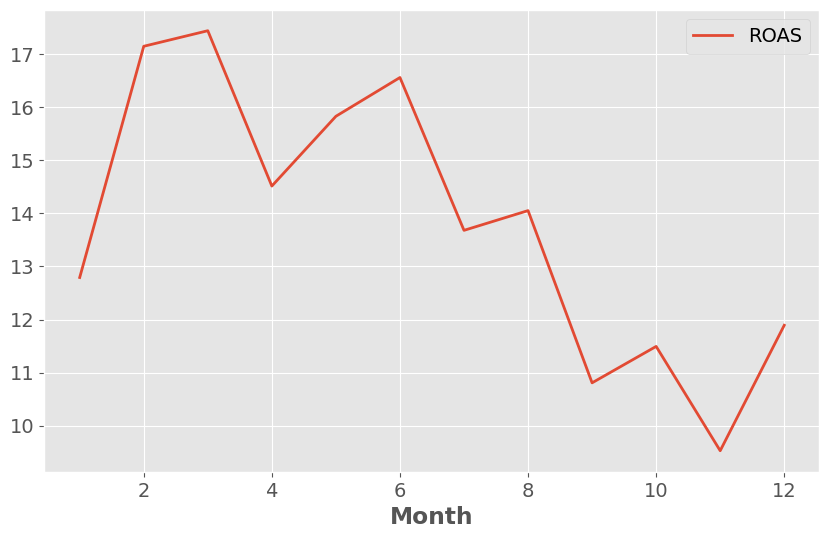

In [16]:
df_recent = monthly.loc["2022-01":]
df_recent["Month"] = df_recent.index.month
monthly_avg2 = df_recent.groupby("Month").mean()


monthly_avg2.plot(y=["ROAS"], kind="line", figsize=(10, 6))


In [14]:
monthly_avg2

,Revenue,ROAS,Spend
Month,,,
1,180847.067651,12.792657,14004.928745
2,205581.752931,17.149097,12744.734945
3,296057.086083,17.442320,16248.245566
4,249694.897140,14.515611,15752.897638
5,274426.935556,15.830032,16435.102853
6,303879.450452,16.560617,16774.918612
7,323575.741603,13.681060,20304.125932
8,226821.653083,14.053013,17101.719947
9,136346.852965,10.808018,13159.146622
